In [1]:
import numpy as np
import collections
import tqdm
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import sys
import random
import time

import mindspore as ms
# from mindquantum.core.circuit import Circuit, controlled
# from mindquantum.core.gates import H, ZZ, RX, RY, XX
# from mindquantum.core.operators import Hamiltonian, QubitOperator
# from mindquantum.framework import MQAnsatzOnlyLayer
from mindquantum.simulator import Simulator
from ansatz import Ansatz

import sys
sys.path.append("/home/zoker/quict")
from QuICT.algorithm.quantum_machine_learning.data import *
from frqi import HIQFRQI
from QuICT.algorithm.quantum_machine_learning.encoding import *
from QuICT.simulation.state_vector import StateVectorSimulator
from QuICT.core.circuit import Circuit
from QuICT.core.gate import *

Please install quict_sim first, you can use 'pip install quict_sim' to install. 
Please install pytorch, torch-geometric, torch-sparse, tensorboard, cupy and quict_ml first, you can use 'pip install quict-ml' to install quict_ml. 
Please install pytorch, cupy and quict_ml first, you can use 'pip install quict-ml' to install quict_ml. 


In [2]:
RESIZE = (4, 4)
QUBIT = int(np.log2(RESIZE[0] * RESIZE[1]) + 2)

Training examples:  60000
Testing examples:  10000
Filtered training examples:  12049
Filtered testing examples:  1968
Label:  tensor(False)
Remaining training examples:  10338
Remaining testing examples:  1793


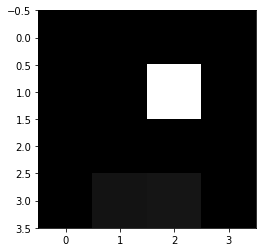

In [3]:
train_data = datasets.MNIST(root="./data/", train=True, download=True)
test_data = datasets.MNIST(root="./data/", train=False, download=True)
train_X = train_data.data
train_Y = train_data.targets
test_X = test_data.data
test_Y = test_data.targets
print("Training examples: ", len(train_Y))
print("Testing examples: ", len(test_Y))


def filter_targets(X, Y, class0=3, class1=6):
    idx = (Y == class0) | (Y == class1)
    X, Y = (X[idx], Y[idx])
    Y = Y == class1
    return X, Y


train_X, train_Y = filter_targets(train_X, train_Y)
test_X, test_Y = filter_targets(test_X, test_Y)
print("Filtered training examples: ", len(train_Y))
print("Filtered testing examples: ", len(test_Y))
print("Label: ", train_Y[200])
plt.imshow(train_X[200], cmap="gray")


def downscale(X, resize):
    transform = transforms.Resize(size=resize)
    X = transform(X) / 255.0
    return X


resized_train_X = downscale(train_X, RESIZE)
resized_test_X = downscale(test_X, RESIZE)
plt.imshow(resized_train_X[200], cmap="gray")


def remove_conflict(X, Y, resize):
    x_dict = collections.defaultdict(set)
    for x, y in zip(X, Y):
        x_dict[tuple(x.numpy().flatten())].add(y.item())
    X_rmcon = []
    Y_rmcon = []
    for x in x_dict.keys():
        if len(x_dict[x]) == 1:
            X_rmcon.append(np.array(x).reshape(resize))
            Y_rmcon.append(list(x_dict[x])[0])
    X = np.array(X_rmcon)
    Y = np.array(Y_rmcon)
    return X, Y


nocon_train_X, nocon_train_Y = remove_conflict(resized_train_X, train_Y, RESIZE)
nocon_test_X, nocon_test_Y = remove_conflict(resized_test_X, test_Y, RESIZE)
print("Remaining training examples: ", len(nocon_train_Y))
print("Remaining testing examples: ", len(nocon_test_Y))


def binary_img(X, threshold):
    X = X > threshold
    X = X.astype(np.int16)
    return X


threshold = 0.5
bin_train_X = binary_img(nocon_train_X, threshold)
bin_test_X = binary_img(nocon_test_X, threshold)


def encoding_img(X, encoding):
    data_circuits = []
    for i in tqdm.tqdm(range(len(X))):
        data_circuit = encoding(X[i])
        data_circuits.append(data_circuit)

    return data_circuits


In [4]:
EPOCH = 3  # 训练总轮数
BATCH_SIZE = 1  # 一次迭代使用的样本数
LR = 0.001  # 梯度下降的学习率
SEED = 17  # 随机数种子

np.random.seed(SEED)
random.seed(SEED)
ms.set_seed(SEED)

In [5]:
train_X = bin_train_X
test_X = bin_test_X
train_Y = nocon_train_Y
test_Y = nocon_test_Y

train_dataset = Dataset(train_X, train_Y)
test_dataset = Dataset(test_X, test_Y)
train_loader = DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True
)
test_loader = DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True
)

In [6]:
# import torch.utils.tensorboard

# now_time = time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime(time.time()))
# model_path = "D:/ICT/dev_qml/quict/QNN2.0_MNIST_" + now_time + "/"
# tb = torch.utils.tensorboard.SummaryWriter(log_dir=model_path + "logs")

In [7]:
# encoding = FRQI(2)
# data_circuit = encoding()
# data_circuit.as_encoder()
# ansatz = Ansatz(QUBIT)
# model_circuit = ansatz()
# model_circuit.as_ansatz()
# ham = Hamiltonian(QubitOperator('Z'+str(QUBIT-1), -1))
# sim = Simulator('mqvector', QUBIT)

In [8]:
quict_frqi = FRQI(2)
hiq_frqi = HIQFRQI(2)
quict_sim = StateVectorSimulator(device="CPU")
n_qubits = int(np.log2(RESIZE[0] * RESIZE[1])) + 1
hiq_sim = Simulator('mqvector', n_qubits)


loader = tqdm.tqdm(train_loader, leave=True)
for it, (x_train, y_train) in enumerate(loader):
    hiq_sim.reset()
    quict_datacir = quict_frqi(x_train[0], use_qic=False)
    hiq_datacir = hiq_frqi(x_train[0])
    quict_sv = quict_sim.run(quict_datacir)
    hiq_sim.apply_circuit(hiq_datacir)
    hiq_sv = hiq_sim.get_qs()
    if abs(np.linalg.norm(quict_sv - hiq_sv)) > 1e-12:
        print(it)
        print("FALSE")
        print(x_train[0])
        print(quict_sv)
        print(hiq_sv)
        hiq_datacir.svg()
        break


100%|██████████| 10338/10338 [00:37<00:00, 277.11it/s]


In [9]:
hiq_sim.reset()
frqi = HIQFRQI(2)
img = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0]])
circuit = frqi(img)
hiq_sim.apply_circuit(circuit)
sv = hiq_sim.get_qs()
circuit.svg()
# print(sv)

# circuit.matrix()

In [10]:
cir = Circuit(5)
mcr = MultiControlRotation(GateType.ry, np.pi)

H | cir(0)
H | cir(1)
H | cir(2)
H | cir(3)
X | cir(1)
X | cir(3)
mcr(4) | cir([0, 1, 2, 3, 4])
X | cir(1)
X | cir(2)
X | cir(3)
mcr(4) | cir([0, 1, 2, 3, 4])
X | cir(2)
sv = quict_sim.run(cir)
# print(sv)
cir.matrix()

array([[ 2.50000000e-01+0.j,  2.72866517e-19+0.j,  2.50000000e-01+0.j,
        ...,  2.72866517e-19+0.j,  2.50000000e-01+0.j,
         2.72866517e-19+0.j],
       [ 2.72866517e-19+0.j,  2.50000000e-01+0.j,  2.72866517e-19+0.j,
        ...,  2.50000000e-01+0.j,  2.72866517e-19+0.j,
         2.50000000e-01+0.j],
       [ 2.50000000e-01+0.j,  4.09299776e-19+0.j, -2.50000000e-01+0.j,
        ...,  4.09299776e-19+0.j, -2.50000000e-01+0.j,
        -4.09299776e-19+0.j],
       ...,
       [-5.08307411e-18+0.j,  2.50000000e-01+0.j, -5.08307411e-18+0.j,
        ..., -2.50000000e-01+0.j,  5.08307411e-18+0.j,
        -2.50000000e-01+0.j],
       [ 2.50000000e-01+0.j,  4.77059033e-18+0.j, -2.50000000e-01+0.j,
        ..., -4.77059033e-18+0.j,  2.50000000e-01+0.j,
         4.77059033e-18+0.j],
       [ 1.85581979e-18+0.j,  2.50000000e-01+0.j, -1.85581979e-18+0.j,
        ..., -2.50000000e-01+0.j,  1.85581979e-18+0.j,
         2.50000000e-01+0.j]])

In [11]:
# encoding = FRQI(2)
# data_circuit = encoding()
# data_circuit.as_encoder()
# ansatz = Ansatz(QUBIT)
# model_circuit = ansatz()
# model_circuit.as_ansatz()
# ham = Hamiltonian(QubitOperator('Z'+str(QUBIT-1), -1))
# sim = Simulator('mqvector', QUBIT)

# # train epoch
# for ep in range(EPOCH):
#     loader = tqdm.tqdm(
#         train_loader, desc="Training epoch {}".format(ep + 1), leave=True
#     )
#     # train iteration
#     for it, (x_train, y_train) in enumerate(loader):
#         x_train = [encoding(x) for x in x_train]
#         for data_circuit in x_train:
#             circuit = Circuit()
#             circuit += data_circuit
#             circuit += model_circuit
#             grad_ops = sim.get_expectation_with_grad(ham, circuit)
#             print(grad_ops)
#             measure_result, encoder_grad, ansatz_grad = grad_ops(encoder_data, ansatz_data)

#             print('Measurement result: ', measure_result)
#             print('Gradient of encoder parameters: ', encoder_grad)
#             print('Gradient of ansatz parameters: ', ansatz_grad)